# COGNITION_v2

In [1]:
#external libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import plotly
import plotly.subplots as sb
import plotly.express as px
import plotly.graph_objects as go
import dotenv
import pandas as pd
import scipy.fft as fft
import scipy.signal as sg
import scipy.io as sio
import pyedflib

#project library
from spinco import *

#environment variables
dotenv.load_dotenv('lab.env')

#project variables
datapath = os.environ['DATAPATH']
cognipath = datapath+'/COGNITION_v2'


## load EDF's


In [13]:
edfpath=cognipath+'/EDF_EEG/'
files=os.listdir(edfpath)

In [14]:
files

['COG001_EEG.edf',
 'COG002_EEG.edf',
 'COG003_EEG.edf',
 'COG004_EEG.edf',
 'COG005_EEG.edf',
 'COG006_EEG.edf',
 'COG007_EEG.edf',
 'COG008_EEG.edf',
 'COG009_EEG.edf',
 'COG010_EEG.edf',
 'COG011_EEG.edf',
 'COG012_EEG.edf',
 'COG013_EEG.edf',
 'COG014_EEG.edf',
 'COG015_EEG.edf',
 'COG016_EEG.edf',
 'COG017_EEG.edf',
 'COG018_EEG.edf',
 'COG019_EEG.edf']

In [15]:
channels=['C3','C4','F3','F4']
signals={}

In [16]:
for file in files:
    subjectId=file[0:6]
    print(subjectId)
    signals[subjectId]={}
    try:
        aux=pyedflib.highlevel.read_edf(edfpath+file)
        thisSignals=aux[0]
        thisHeaders=aux[1]
        for header,signal in zip(thisHeaders,thisSignals):
            if header['label'] in channels:
                signals[subjectId][header['label']]=signal
    except:
        print("file "+file+" corrupted")

COG001
COG002
COG003
COG004
COG005
COG006
COG007
COG008
COG009
COG010
COG011
COG012
COG013
COG014
COG015
COG016
COG017
COG018
COG019


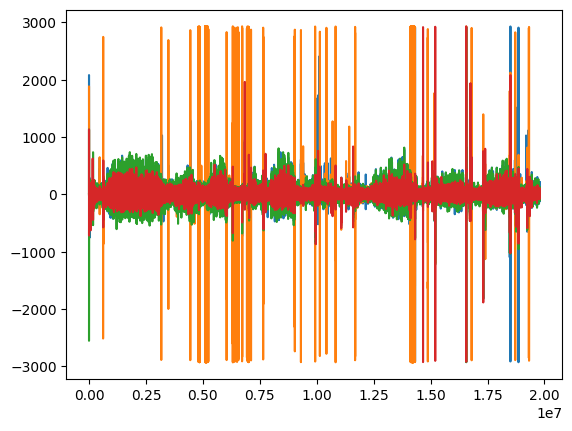

In [9]:
for key,signal in signals['COG001'].items():
    plt.plot(signal)

In [46]:
signalsMetadata=pd.DataFrame()
for key_subject, signals_subject in signals.items():
    for key_channel, signal_channel in signals_subject.items():
        #resample to 200 Hz
        signal_channel=sg.resample_poly(signal_channel,up=2,down=5)
        dumpPickle(cognipath+'/signals/'+key_subject+'_'+key_channel+'.pkl',signal_channel)

        filename=key_subject+'_'+key_channel+'.pkl'
        row=pd.DataFrame({
            'filename':[filename],
            'subjectId':[key_subject],
            'channel': [key_channel],
            'duration':[len(signal_channel)/200],
            'samplerate':[200]
        })
        signalsMetadata=pd.concat([signalsMetadata,row])

signalsMetadata=signalsMetadata.reset_index(drop=True)

In [48]:
signalsMetadata

,filename,subjectId,channel,duration,samplerate
0,COG001_F3.pkl,COG001,F3,39600.0,200
1,COG001_C3.pkl,COG001,C3,39600.0,200
2,COG001_F4.pkl,COG001,F4,39600.0,200
3,COG001_C4.pkl,COG001,C4,39600.0,200
4,COG002_F3.pkl,COG002,F3,39600.0,200
...,...,...,...,...,...
71,COG018_C4.pkl,COG018,C4,39600.0,200
72,COG019_F3.pkl,COG019,F3,41400.0,200
73,COG019_C3.pkl,COG019,C3,41400.0,200
74,COG019_F4.pkl,COG019,F4,41400.0,200


In [50]:
signalsMetadata.to_csv(cognipath+'/signals/signalsMetadata.csv',index=False)

In [59]:
def channel2altChannel(channel):
    if channel=='C3':
        return 'c3'
    elif channel=='C4':
        return 'c4'
    elif channel=='F3':
        return 'fp1'
    elif channel=='F4':
        return 'fp2'

In [61]:
signalsMetadata['alt_channel']=signalsMetadata.apply(lambda row: channel2altChannel(row.channel),axis=1)

In [62]:
signalsMetadata

,filename,subjectId,channel,duration,samplerate,alt_channel
0,COG001_F3.pkl,COG001,F3,39600.0,200,fp1
1,COG001_C3.pkl,COG001,C3,39600.0,200,c3
2,COG001_F4.pkl,COG001,F4,39600.0,200,fp2
3,COG001_C4.pkl,COG001,C4,39600.0,200,c4
4,COG002_F3.pkl,COG002,F3,39600.0,200,fp1
...,...,...,...,...,...,...
71,COG018_C4.pkl,COG018,C4,39600.0,200,c4
72,COG019_F3.pkl,COG019,F3,41400.0,200,fp1
73,COG019_C3.pkl,COG019,C3,41400.0,200,c3
74,COG019_F4.pkl,COG019,F4,41400.0,200,fp2


# Save Annotations

In [51]:
annopath=cognipath+'/MARCAS/'
files=os.listdir(annopath)

In [78]:
annotations=pd.DataFrame()
for key,row in signalsMetadata.iterrows():
    aux=pd.read_csv(annopath+row.subjectId+'_spindle_'+row.alt_channel+'.csv')
    aux['subjectId']=row.subjectId
    aux['channel']=row.channel
    aux['type']='spindle'
    annotations=pd.concat((annotations,aux))

annotations=annotations.reset_index(drop=True)

In [83]:
annotations['startTime']=annotations['Inicio']
annotations['stopTime']=annotations['Fin']
annotations['duration']=annotations['Duracion']
annotations['phase']=annotations['Fase']
annotations=annotations[['subjectId','channel','startTime','stopTime','duration','phase','type']]

In [84]:
annotations.groupby(['subjectId','channel']).count()

startTime  stopTime  duration  phase  type
subjectId channel                                            
COG001    C3             214       214       214    214   214
          C4             232       232       232    232   232
          F3             984       984       984    984   984
          F4             853       853       853    853   853
COG002    C3             240       240       240    240   240
          C4             110       110       110    110   110
          F3             173       173       173    173   173
          F4             102       102       102    102   102
COG003    C3             849       849       849    849   849
          C4            1162      1162      1162   1162  1162
          F3             338       338       338    338   338
          F4             563       563       563    563   563
COG004    C3             419       419       419    419   419
          C4             273       273       273    273   273
          F3             644       644       644    644   644
          F4             572       572       572    572   572
COG005    C3             316       316       316    316   316
          C4             289       289       289    289   289
          F3            1539      1539      1539   1539  1539
          F4             940       940       940    940   940
COG006    C3             226       226       226    226   226
          C4             108       108       108    108   108
          F3             539       539       539    539   539
          F4             462       462       462    462   462
COG007    C3             372       372       372    372   372
          C4              49        49        49     49    49
          F3             503       503       503    503   503
          F4             583       583       583    583   583
COG008    C3              47        47        47     47    47
          C4             125       125       125    125   125
          F3             113       113       113    113   113
          F4             172       172       172    172   172
COG009    C3             102       102       102    102   102
          C4              31        31        31     31    31
          F3             206       206       206    206   206
          F4             239       239       239    239   239

In [86]:
cognipath

'D:/SpinCo/COGNITION_v2'

In [88]:
annotations.to_csv(cognipath+'/annotations/annotations.csv',index=False)

In [97]:
annotations['startInd']=annotations.apply(
    lambda row: seconds2index(row.startTime,200) , axis=1)
annotations['stopInd']=annotations.apply(
    lambda row: seconds2index(row.stopTime,200) , axis=1)

In [98]:
annotations=annotations[annotations.type=="spindle"].reset_index(drop=True)
annotations

,subjectId,channel,startTime,stopTime,duration,phase,type,startInd,stopInd
0,COG001,F3,1798.073930,1798.696491,0.622561,2,spindle,359615,359739
1,COG001,F3,1868.599222,1869.591433,0.992211,2,spindle,373720,373918
2,COG001,F3,1914.163425,1915.369645,1.206220,2,spindle,382833,383074
3,COG001,F3,1916.653694,1917.840459,1.186765,2,spindle,383331,383568
4,COG001,F3,1928.638133,1929.902718,1.264585,2,spindle,385728,385981
...,...,...,...,...,...,...,...,...,...
14684,COG009,C4,35328.677042,35329.338519,0.661477,3,spindle,7065735,7065868
14685,COG009,C4,35440.817120,35441.575876,0.758756,3,spindle,7088163,7088315
14686,COG009,C4,35521.498055,35522.373535,0.875480,3,spindle,7104300,7104475
14687,COG009,C4,39504.552529,39505.077815,0.525286,3,spindle,7900911,7901016
